# IBM Deep Learning Capstone Project


These are my notes/implementation of the IBM Deep Learning Capstone project. During this project, we uptrain a pre-trained model to specialize on building crack detection. This would be used in a hypothetical scenario where we are investigating buildings for cracks to see if they pass some sort of test for building regulations.

## **0.0** Imports

In [ ]:
!pip install skillsnetwork

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.0 MB/s eta 0:00:00


In [ ]:
from PIL import Image
from matplotlib.pyplot import imshow
import pandas
import matplotlib.pylab as plt
import os
import glob
import skillsnetwork
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn

## **1.0** Loading data

In [ ]:
# get data from ibm object storage and unzip

if not os.path.exists('/resources/data'):
    os.makedirs('/resources/data')

await skillsnetwork.prepare("https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip", path = "/resources/data", overwrite=True)

  0%|          | 0/40000 [00:00<?, ?it/s]

Saved to '../resources/data'


In [ ]:
# paths are:
# /resources/data/Positive/*
# /resources/data/Negative/*

# Get all negative files
directory = '/resources/data/'
negative = 'Negative'
negative_file_path = os.path.join(directory, negative)
negative_files = [os.path.join(negative_file_path, file) for file in os.listdir(negative_file_path) if file.endswith('.jpg')]
negative_files.sort()

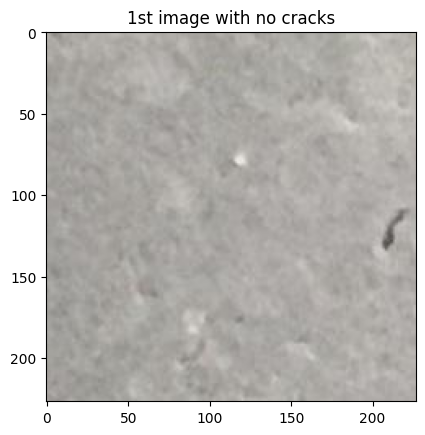

In [ ]:
# show first negative image
image1 = Image.open(negative_files[0])

plt.imshow(image1)
plt.title("1st image with no cracks")
plt.show()

In [ ]:
positive = 'Positive'
positive_file_path = os.path.join(directory, positive)
positive_files = [os.path.join(positive_file_path, file) for file in os.listdir(positive_file_path) if file.endswith('.jpg')]
positive_files.sort()

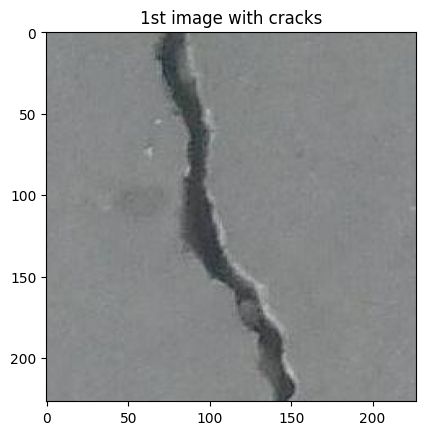

In [ ]:
# show first positive image
image1 = Image.open(positive_files[0])

plt.imshow(image1)
plt.title("1st image with cracks")
plt.show()

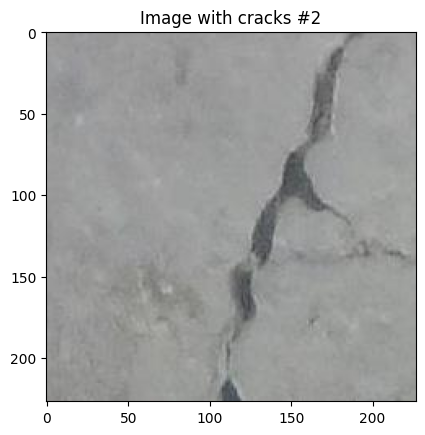

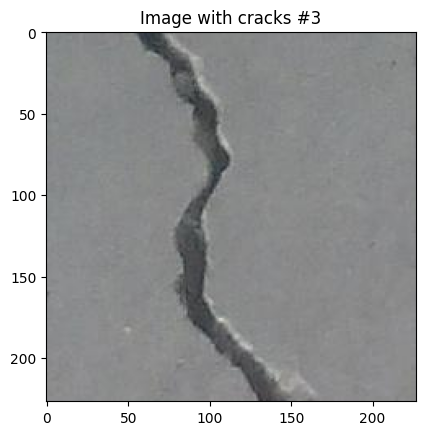

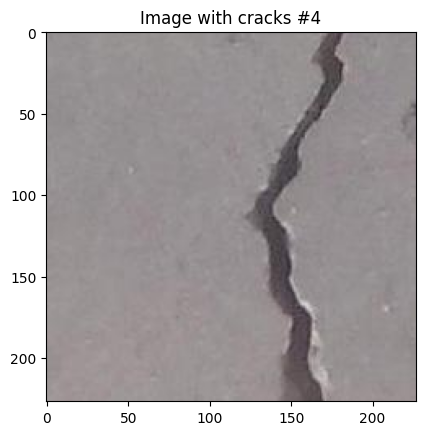

In [ ]:
# show the next three images with cracks:

for i, file in enumerate(positive_files[1:4]):
  image = Image.open(file)
  plt.imshow(image)
  plt.title(f"Image with cracks #{i+2}")
  plt.show()

## **2.0** Data Preparation

In [ ]:
# get number of samples
number_of_samples = len(positive_files) + len(negative_files)

In [ ]:
number_of_samples

40000

In [ ]:
# create label tensor
Y = torch.zeros([number_of_samples])

In [ ]:
Y

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [ ]:
# there are floats in the tensor, we want them to be of long type
Y = Y.type(torch.LongTensor)

In [ ]:
# assign even to 1, odd to 0
Y[::2] = 1
Y[1::2] = 0

In [ ]:
# create list with all files, even indeces corresponding to positive and odd corresponding to negative

all_files = [None] * number_of_samples

for i in range(number_of_samples):
  if i%2 == 0:
    all_files[i] = positive_files[i//2]
    all_files[i+1] = negative_files[i//2]

In [ ]:
# create dataset class

class Dataset(Dataset):
  def __init__(self, transform=None, train=True):
    directory = '/resources/data'
    positive = 'Positive'
    negative = 'Negative'

    positive_file_path=os.path.join(directory, positive)
    negative_file_path=os.path.join(directory, negative)
    positive_files = [os.path.join(positive_file_path, file) for file in os.listdir(positive_file_path)]
    positive_files.sort()
    negative_files = [os.path.join(negative_file_path, file) for file in os.listdir(negative_file_path)]
    negative_files.sort()

    # files
    number_of_samples = len(positive_files) + len(negative_files)
    self.all_files = [None]*number_of_samples
    self.all_files[::2] = positive_files
    self.all_files[1::2] = negative_files

    # Transform that will be used on images
    self.transform = transform

    # labels, correspond to all_file class by index
    self.Y = torch.zeros([number_of_samples]).type(torch.LongTensor) # we want them to be "whole numbers"
    self.Y[::2] = 1
    self.Y[1::2] = 0

    if train:
      self.Y = self.Y[:30000]
      self.all_files = self.all_files[:30000]
      self.len = len(self.all_files)
    else:
      self.Y = self.Y[30000:]
      self.all_files = self.all_files[30000:]
      self.len = len(self.all_files)

  # Get length
  def __len__(self):
    return self.len

  # Get item
  def __getitem__(self, idx):
    image = Image.open(self.all_files[idx])
    y = self.Y[idx]

    # if any transform, apply to image
    if self.transform:
      image = self.transform(image)

    return image, y

## **3.0** Linear Classifier

Before uptraining ResNet, we will first create a simple model of our own to test the dataset.





In [ ]:
# define the transformation function we will use to normalize data (provided by IBM)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform =transforms.Compose([ transforms.ToTensor(), transforms.Normalize(mean, std)])

In [ ]:
# create train and validation datasets
dataset_train = Dataset(train = True, transform = transform)
dataset_val = Dataset(train = False, transform = transform)

In [ ]:
# get shape of image
dataset_train[0][0].shape

torch.Size([3, 227, 227])

In [ ]:
# RGB, 227 x 227, so the flattened size would be:
size_of_image = 3*227*227
size_of_image

154587

In [ ]:
# set seed
torch.manual_seed(0)

In [ ]:
# create custom model module
class model(nn.Module):
  def __init__(self, D_in = 3*227*227, D_out = 2):
    super(model, self).__init__()

    self.linear = nn.Linear(D_in, D_out)

  def forward(self, x):
    x = x.view(x.size(0), -1) # x.size(0) takes into account the batch size
    x = self.linear(x)
    return x

In [ ]:
# define new model variable
model = model()

In [ ]:
# define optimizer, criterion
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum= 0.1)
criterion = nn.CrossEntropyLoss()

In [ ]:
# train and test loaders
train_loader = DataLoader(dataset_train, batch_size = 5)
val_loader = DataLoader(dataset_val, batch_size = 5)

In [ ]:
# train the model
COST = []
ACCURACY = []
N_TEST = len(dataset_val)
epochs = 5
for epoch in range(epochs):
  cost = 0
  for x, y in train_loader:
    optimizer.zero_grad()
    yhat = model(x)
    loss = criterion(yhat, y)
    loss.backward()
    optimizer.step()
    cost+=loss.item()
  COST.append(cost)
  correct = 0

  for x_test, y_test in val_loader:
    pred = model(x_test)
    _, yhat = torch.max(pred.data, 1)
    correct += (y_test == yhat).sum().item()
  accuracy = correct / N_TEST
  ACCURACY.append(accuracy)

  print(f"Epoch {epoch+1} cost: {COST[-1]}")
  print(f"Epoch {epoch+1} validation accuracy: {ACCURACY[-1]}")

Epoch 1 cost: 5668862.974322239
Epoch 1 validation accuracy: 0.7948
Epoch 2 cost: 4666378.925817609
Epoch 2 validation accuracy: 0.8136
Epoch 3 cost: 4363477.411061277
Epoch 3 validation accuracy: 0.8041
Epoch 4 cost: 4209279.407986765
Epoch 4 validation accuracy: 0.814
Epoch 5 cost: 4135936.3263852242
Epoch 5 validation accuracy: 0.7639


In [ ]:
# get the highest validation accuracy from the five epochs:
print(f"Peak validation accuracy: {max(ACCURACY)}")

Peak validation accuracy: 0.814


## **4.0** Uptraining Resnet-18

In [ ]:
# resnet18 model
model = models.resnet18(pretrained = True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


In [ ]:
# turn off the hidden layers so we dont train them
for param in model.parameters():
  param.requires_grad=False

In [ ]:
# now, replace the output layer, model.fc, with a layer that connects with the previous and two predicted classes
model.fc = nn.Linear(512, 2) # the previous layerhas 512 output layers

In [ ]:
# define optimizer, criterion
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# train and test loaders
train_loader = DataLoader(dataset_train, batch_size = 100)
val_loader = DataLoader(dataset_val, batch_size = 100)

In [ ]:
# train model

LOSS = []
COST = []
ACCURACY = []
N_TEST = len(dataset_val)
epochs = 5
for epoch in range(epochs):
  cost = 0
  for x, y in train_loader:
    optimizer.zero_grad()
    yhat = model(x)
    loss = criterion(yhat, y)
    loss.backward()
    optimizer.step()
    LOSS.append(loss.item())
    cost+=loss.item()
  COST.append(cost)
  correct = 0

  for x_test, y_test in val_loader:
    pred = model(x_test)
    _, yhat = torch.max(pred.data, 1)
    correct += (y_test == yhat).sum().item()
  accuracy = correct / N_TEST
  ACCURACY.append(accuracy)

  print(f"Epoch {epoch+1} cost: {COST[-1]}")
  print(f"Epoch {epoch+1} validation accuracy: {ACCURACY[-1]}")

Epoch 1 cost: 29.32842242065817
Epoch 1 validation accuracy: 0.9873
Epoch 2 cost: 8.696545580402017
Epoch 2 validation accuracy: 0.9915
Epoch 3 cost: 6.476414804114029
Epoch 3 validation accuracy: 0.9929
Epoch 4 cost: 5.446456697303802
Epoch 4 validation accuracy: 0.9939
Epoch 5 cost: 4.8277609457145445
Epoch 5 validation accuracy: 0.994


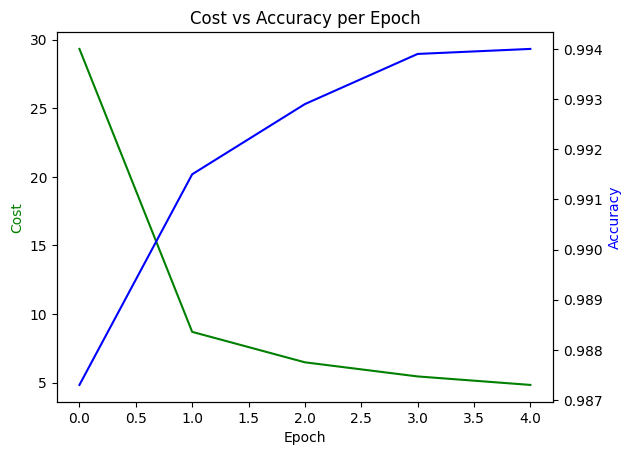

In [ ]:
# plot cost vs accuracy per epoch
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(COST, 'g-')
ax2.plot(ACCURACY, 'b-')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Cost', color='g')
ax2.set_ylabel('Accuracy', color='b')
plt.title("Cost vs Accuracy per Epoch")

plt.show()

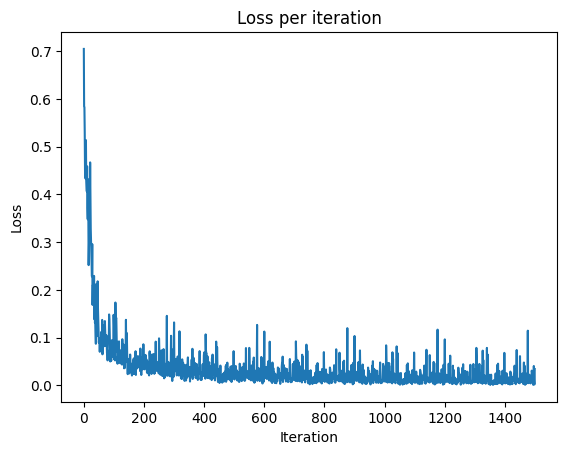

In [ ]:
# Plot loss per iteration

plt.title("Loss per iteration")
plt.plot(LOSS)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

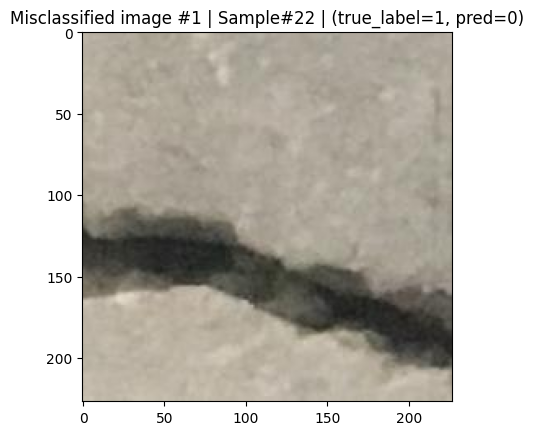

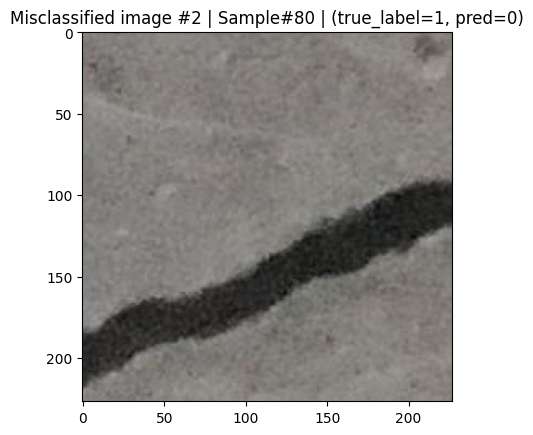

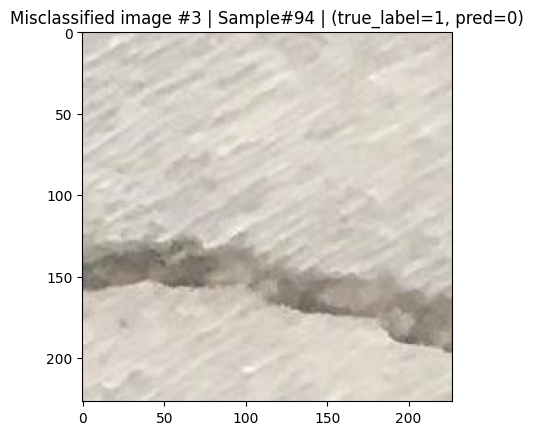

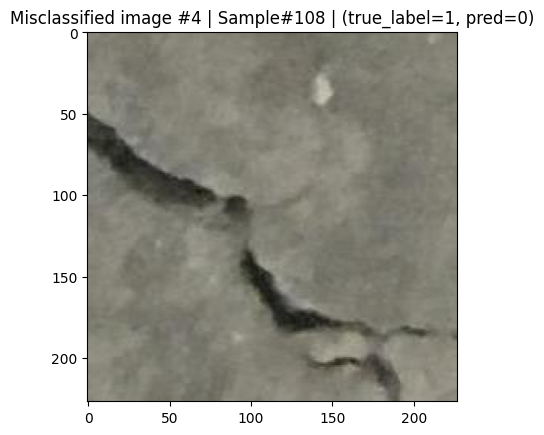

In [ ]:
# Identify the first four misclassified samples

i = 0

# new val_loader with batch size 1
val_loader = DataLoader(dataset_val)

# get validation portion of all_files
val_files = all_files[30000:]

response = []
model.eval()
for j, (image, y) in enumerate(val_loader):
  if i == 4:
    break
  yhat = model(image)
  _, yhat = torch.max(yhat.data, 1)
  true_label = y.item()
  predicted_label = yhat.item()
  if true_label != predicted_label:
    response.append(f"Sample#{j}, true_label={true_label}, pred={predicted_label}")
    img = Image.open(val_files[j])
    plt.imshow(img)
    plt.title(f"Misclassified image #{i+1} | Sample#{j} | (true_label={true_label}, pred={predicted_label})")
    plt.show()
    i+=1

In [ ]:
for r in response:
  print(r)

Sample#22, true_label=1, pred=0
Sample#80, true_label=1, pred=0
Sample#94, true_label=1, pred=0
Sample#108, true_label=1, pred=0
